# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

# Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [-0.01362366 -0.23502158  0.03441346  0.27506765] 0 1.0 False {}
state, action, reward, done, info: [-0.01832409 -0.04040709  0.03991482 -0.00656567] 1 1.0 False {}
state, action, reward, done, info: [-0.01913223  0.15412037  0.0397835  -0.28639261] 1 1.0 False {}
state, action, reward, done, info: [-0.01604982 -0.04154571  0.03405565  0.01856753] 0 1.0 False {}
state, action, reward, done, info: [-0.01688074  0.15307172  0.034427   -0.26317891] 1 1.0 False {}
state, action, reward, done, info: [-0.0138193   0.34768578  0.02916342 -0.54480749] 1 1.0 False {}
state, action, reward, done, info: [-0.00686559  0.54238605  0.01826727 -0.82816088] 1 1.0 False {}
state, action, reward, done, info: [ 0.00398213  0.73725355  0.00170406 -1.11504307] 1 1.0 False {}
state, action, reward, done, info: [ 0.01872721  0.93235309 -0.02059681 -1.40719096] 1 1.0 False {}
state, action, reward, done, info: [ 0.03737427  1.12772449 -0.04874062 -1.70624094] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states and actions for calculating Qs
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    
    # Calculated targetQs
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, actions, targetQs

In [7]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
def model_loss(states, actions, targetQs, # model input data for targetQs
               action_size, hidden_size): # model init for Qs
    
    # Calculating action logits: Used to calculate Qs and targetQs
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    
    # # Calculating targetQs using NEW memory using rewards
    # rewarded_actions_logits = np.multiply(actions_logits, rewards.reshape([-1, 1]))
    # Qs = np.max(rewarded_actions_logits, axis=1)
    
    # # Calculating Qs using NEW memory using actions
    # Onehot vectorizing the actions logits
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_onehot = tf.multiply(actions_logits[:-1], actions_onehot[1:])
    Qs = tf.reduce_max(Qs_onehot, axis=1)
    
    # Calculating the loss: logits/predictions vs labels
    loss = tf.reduce_mean(tf.square(Qs - targetQs[1:]))
    #loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, labels=tf.nn.sigmoid(targetQs[1:])))
    
    return actions_logits, loss

In [9]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [10]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input data

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [11]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
print('state size:{}'.format(state.shape), 
      'action:{}'.format(action)) #(np.max(action) - np.min(action)+1)

state size:(4,) action:1


In [13]:
# Training parameters
train_episodes = 3000          # max number of episodes to learn from
max_steps = 300000000          # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation
batch_size = 500               # number of samples in the memory/ experience as mini-batch size

In [14]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [15]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    
    # Take one random step to get the pole and cart moving
    action = env.action_space.sample()
    state, _, done, _ = env.step(action)
    reward = 1 - float(done)
    memory.buffer.append((action, state, reward))
    
    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [16]:
state, reward, action

(array([ 0.21898302,  0.44043341, -0.23090644, -0.91192026]), 0.0, 0)

In [22]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting after training session/graph
rewards_list = [] # accuracy
loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        env.reset()
        total_reward = 0
        loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            last_action_logits = actions_logits[-1]
            
            # Explore (Env) or Exploit (Model)
            # Take new action, get new state and reward
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # Cumulative rewards
            total_reward += reward

            # Batch from NEW memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])

            # Calculating targetQs/nextQs using NEW memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)            
            rewarded_actions_logits = np.multiply(actions_logits, rewards.reshape([-1, 1]))
            Qs = np.max(rewarded_actions_logits, axis=1)

            # Updating the model using NEW memory and targetQs/nextQs
            feed_dict = {model.states: states, 
                         model.actions: actions, 
                         model.targetQs: Qs} # labelQs
            loss, _ = sess.run([model.loss, model.opt], feed_dict)

            # For average loss in one episode/epoch
            loss_batch.append(loss)

            # At the end of steps/batches loop
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Average loss: {:.4f}'.format(np.mean(loss_batch)),
              'Explore P: {:.4f}'.format(explore_p))
        print('-------------------------------------------------------------------------------')

        # At the end of each episode/epoch
        # total rewards and losses for plotting
        rewards_list.append((ep, total_reward))
        loss_list.append((ep, np.mean(loss_batch)))
        
    # At the end of all training episodes/epochs
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 23.0 Average loss: 0.0160 Explore P: 0.9976
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 11.0 Average loss: 0.0031 Explore P: 0.9964
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 33.0 Average loss: 0.0072 Explore P: 0.9931
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 15.0 Average loss: 0.0330 Explore P: 0.9915
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Epis

-------------------------------------------------------------------------------
Episode: 36 Total reward: 29.0 Average loss: 13430.5068 Explore P: 0.9153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 37 Total reward: 36.0 Average loss: 18440.0820 Explore P: 0.9120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 38 Total reward: 14.0 Average loss: 24001.1055 Explore P: 0.9106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 39 Total reward: 10.0 Average loss: 26987.9258 Explore P: 0.9096
-------------------------------------------------------------------------------
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 71 Total reward: 30.0 Average loss: 279550752.0000 Explore P: 0.8284
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 72 Total reward: 19.0 Average loss: 343738048.0000 Explore P: 0.8267
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 73 Total reward: 25.0 Average loss: 439700416.0000 Explore P: 0.8246
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 74 Total reward: 10.0 Average loss: 590504192.0000 Explore P: 0.8237
-------------------------------------------------------------------------------
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 106 Total reward: 14.0 Average loss: 110955503616.0000 Explore P: 0.7020
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 107 Total reward: 36.0 Average loss: 108353765376.0000 Explore P: 0.6995
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 108 Total reward: 129.0 Average loss: 93790863360.0000 Explore P: 0.6906
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 109 Total reward: 82.0 Average loss: 84514971648.0000 Explore P: 0.6849
-------------------------------------------------------------------------------
---------------------------------

-------------------------------------------------------------------------------
Episode: 140 Total reward: 190.0 Average loss: 23964432728064.0000 Explore P: 0.5552
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 141 Total reward: 41.0 Average loss: 41121895940096.0000 Explore P: 0.5529
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 142 Total reward: 27.0 Average loss: 57418448896000.0000 Explore P: 0.5514
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 143 Total reward: 83.0 Average loss: 63784014053376.0000 Explore P: 0.5469
-------------------------------------------------------------------------------
-----------------------

-------------------------------------------------------------------------------
Episode: 174 Total reward: 201.0 Average loss: 174116766220288.0000 Explore P: 0.3358
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 175 Total reward: 124.0 Average loss: 264147585466368.0000 Explore P: 0.3317
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 176 Total reward: 24.0 Average loss: 340444508585984.0000 Explore P: 0.3309
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 177 Total reward: 104.0 Average loss: 431879496925184.0000 Explore P: 0.3276
-------------------------------------------------------------------------------
-----------------

-------------------------------------------------------------------------------
Episode: 208 Total reward: 202.0 Average loss: 281481788260352.0000 Explore P: 0.1557
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 209 Total reward: 171.0 Average loss: 352331099013120.0000 Explore P: 0.1532
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 210 Total reward: 19.0 Average loss: 495075578609664.0000 Explore P: 0.1529
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 211 Total reward: 14.0 Average loss: 739341106151424.0000 Explore P: 0.1527
-------------------------------------------------------------------------------
------------------

-------------------------------------------------------------------------------
Episode: 242 Total reward: 126.0 Average loss: 573114127745024.0000 Explore P: 0.1317
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 243 Total reward: 125.0 Average loss: 482582424715264.0000 Explore P: 0.1302
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 244 Total reward: 138.0 Average loss: 502024198160384.0000 Explore P: 0.1285
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 245 Total reward: 125.0 Average loss: 414019915612160.0000 Explore P: 0.1271
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 276 Total reward: 499.0 Average loss: 8168598405120.0000 Explore P: 0.0512
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 277 Total reward: 383.0 Average loss: 4040548417536.0000 Explore P: 0.0496
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 278 Total reward: 173.0 Average loss: 11340550766592.0000 Explore P: 0.0489
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 279 Total reward: 169.0 Average loss: 16133093588992.0000 Explore P: 0.0483
-------------------------------------------------------------------------------
----------------------

-------------------------------------------------------------------------------
Episode: 312 Total reward: 9.0 Average loss: 36706430484480.0000 Explore P: 0.0450
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 313 Total reward: 8.0 Average loss: 35857490771968.0000 Explore P: 0.0449
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 314 Total reward: 9.0 Average loss: 34811343273984.0000 Explore P: 0.0449
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 315 Total reward: 9.0 Average loss: 33519378104320.0000 Explore P: 0.0449
-------------------------------------------------------------------------------
----------------------------

-------------------------------------------------------------------------------
Episode: 348 Total reward: 9.0 Average loss: 10856293203968.0000 Explore P: 0.0438
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 349 Total reward: 9.0 Average loss: 10447787917312.0000 Explore P: 0.0438
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 350 Total reward: 8.0 Average loss: 10131538444288.0000 Explore P: 0.0438
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 351 Total reward: 8.0 Average loss: 9887191924736.0000 Explore P: 0.0437
-------------------------------------------------------------------------------
-----------------------------

-------------------------------------------------------------------------------
Episode: 383 Total reward: 8.0 Average loss: 79783161495552.0000 Explore P: 0.0427
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 384 Total reward: 8.0 Average loss: 80439075143680.0000 Explore P: 0.0427
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 385 Total reward: 9.0 Average loss: 81727062016000.0000 Explore P: 0.0427
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 386 Total reward: 9.0 Average loss: 82325966684160.0000 Explore P: 0.0426
-------------------------------------------------------------------------------
----------------------------

-------------------------------------------------------------------------------
Episode: 419 Total reward: 10.0 Average loss: 93086545870848.0000 Explore P: 0.0416
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 420 Total reward: 10.0 Average loss: 93259678351360.0000 Explore P: 0.0416
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 421 Total reward: 9.0 Average loss: 93628944875520.0000 Explore P: 0.0415
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 422 Total reward: 9.0 Average loss: 93543733395456.0000 Explore P: 0.0415
-------------------------------------------------------------------------------
--------------------------

-------------------------------------------------------------------------------
Episode: 456 Total reward: 9.0 Average loss: 94363199733760.0000 Explore P: 0.0405
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 457 Total reward: 8.0 Average loss: 94807837900800.0000 Explore P: 0.0405
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 458 Total reward: 8.0 Average loss: 94905263194112.0000 Explore P: 0.0405
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 459 Total reward: 9.0 Average loss: 95444038320128.0000 Explore P: 0.0404
-------------------------------------------------------------------------------
----------------------------

-------------------------------------------------------------------------------
Episode: 494 Total reward: 11.0 Average loss: 100397653950464.0000 Explore P: 0.0394
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 495 Total reward: 10.0 Average loss: 99943268220928.0000 Explore P: 0.0394
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 496 Total reward: 9.0 Average loss: 99580997795840.0000 Explore P: 0.0394
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 497 Total reward: 9.0 Average loss: 99872409649152.0000 Explore P: 0.0393
-------------------------------------------------------------------------------
-------------------------

-------------------------------------------------------------------------------
Episode: 528 Total reward: 10.0 Average loss: 100401873420288.0000 Explore P: 0.0385
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 529 Total reward: 10.0 Average loss: 100214841016320.0000 Explore P: 0.0384
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 530 Total reward: 8.0 Average loss: 100481103822848.0000 Explore P: 0.0384
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 531 Total reward: 8.0 Average loss: 100304246800384.0000 Explore P: 0.0384
-------------------------------------------------------------------------------
----------------------

-------------------------------------------------------------------------------
Episode: 564 Total reward: 9.0 Average loss: 99234967715840.0000 Explore P: 0.0375
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 565 Total reward: 9.0 Average loss: 99258137051136.0000 Explore P: 0.0375
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 566 Total reward: 9.0 Average loss: 99321924026368.0000 Explore P: 0.0375
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 567 Total reward: 9.0 Average loss: 99681317158912.0000 Explore P: 0.0374
-------------------------------------------------------------------------------
----------------------------

-------------------------------------------------------------------------------
Episode: 600 Total reward: 8.0 Average loss: 101607710654464.0000 Explore P: 0.0366
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 601 Total reward: 9.0 Average loss: 100986500677632.0000 Explore P: 0.0365
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 602 Total reward: 7.0 Average loss: 101409185857536.0000 Explore P: 0.0365
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 603 Total reward: 9.0 Average loss: 101102909390848.0000 Explore P: 0.0365
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 636 Total reward: 9.0 Average loss: 96756687699968.0000 Explore P: 0.0357
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 637 Total reward: 7.0 Average loss: 96776619032576.0000 Explore P: 0.0357
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 638 Total reward: 9.0 Average loss: 96240561815552.0000 Explore P: 0.0356
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 639 Total reward: 9.0 Average loss: 95999146065920.0000 Explore P: 0.0356
-------------------------------------------------------------------------------
----------------------------

-------------------------------------------------------------------------------
Episode: 673 Total reward: 9.0 Average loss: 96204415303680.0000 Explore P: 0.0348
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 674 Total reward: 9.0 Average loss: 96270517534720.0000 Explore P: 0.0348
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 675 Total reward: 11.0 Average loss: 95867050655744.0000 Explore P: 0.0348
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 676 Total reward: 8.0 Average loss: 96497706205184.0000 Explore P: 0.0347
-------------------------------------------------------------------------------
---------------------------

-------------------------------------------------------------------------------
Episode: 710 Total reward: 12.0 Average loss: 102282062462976.0000 Explore P: 0.0339
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 711 Total reward: 8.0 Average loss: 101770701307904.0000 Explore P: 0.0339
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 712 Total reward: 8.0 Average loss: 101645576830976.0000 Explore P: 0.0339
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 713 Total reward: 8.0 Average loss: 101114200457216.0000 Explore P: 0.0339
-------------------------------------------------------------------------------
-----------------------

-------------------------------------------------------------------------------
Episode: 747 Total reward: 8.0 Average loss: 97957735038976.0000 Explore P: 0.0331
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 748 Total reward: 8.0 Average loss: 97612879364096.0000 Explore P: 0.0331
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 749 Total reward: 9.0 Average loss: 97676372738048.0000 Explore P: 0.0331
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 750 Total reward: 9.0 Average loss: 97767665958912.0000 Explore P: 0.0331
-------------------------------------------------------------------------------
----------------------------

-------------------------------------------------------------------------------
Episode: 783 Total reward: 8.0 Average loss: 100300664864768.0000 Explore P: 0.0324
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 784 Total reward: 10.0 Average loss: 100638180507648.0000 Explore P: 0.0323
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 785 Total reward: 7.0 Average loss: 101338662830080.0000 Explore P: 0.0323
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 786 Total reward: 8.0 Average loss: 100987767357440.0000 Explore P: 0.0323
-------------------------------------------------------------------------------
-----------------------

-------------------------------------------------------------------------------
Episode: 820 Total reward: 9.0 Average loss: 104746501275648.0000 Explore P: 0.0316
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 821 Total reward: 8.0 Average loss: 105092892065792.0000 Explore P: 0.0316
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 822 Total reward: 8.0 Average loss: 105122604515328.0000 Explore P: 0.0315
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 823 Total reward: 7.0 Average loss: 105091407282176.0000 Explore P: 0.0315
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 855 Total reward: 9.0 Average loss: 103327677284352.0000 Explore P: 0.0309
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 856 Total reward: 9.0 Average loss: 103719442055168.0000 Explore P: 0.0308
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 857 Total reward: 9.0 Average loss: 104332800294912.0000 Explore P: 0.0308
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 858 Total reward: 9.0 Average loss: 104879058059264.0000 Explore P: 0.0308
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 891 Total reward: 8.0 Average loss: 105849905217536.0000 Explore P: 0.0301
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 892 Total reward: 9.0 Average loss: 105705696657408.0000 Explore P: 0.0301
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 893 Total reward: 7.0 Average loss: 105326850342912.0000 Explore P: 0.0301
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 894 Total reward: 8.0 Average loss: 105006212579328.0000 Explore P: 0.0301
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 925 Total reward: 8.0 Average loss: 102875002830848.0000 Explore P: 0.0295
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 926 Total reward: 9.0 Average loss: 102693725011968.0000 Explore P: 0.0295
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 927 Total reward: 7.0 Average loss: 102520181489664.0000 Explore P: 0.0295
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 928 Total reward: 8.0 Average loss: 102359967465472.0000 Explore P: 0.0295
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 961 Total reward: 8.0 Average loss: 107687161364480.0000 Explore P: 0.0288
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 962 Total reward: 9.0 Average loss: 107918686945280.0000 Explore P: 0.0288
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 963 Total reward: 7.0 Average loss: 108158240423936.0000 Explore P: 0.0288
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 964 Total reward: 8.0 Average loss: 108095309086720.0000 Explore P: 0.0288
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 997 Total reward: 9.0 Average loss: 103839533367296.0000 Explore P: 0.0282
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 998 Total reward: 9.0 Average loss: 103820273123328.0000 Explore P: 0.0282
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 999 Total reward: 7.0 Average loss: 104044945211392.0000 Explore P: 0.0282
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1000 Total reward: 10.0 Average loss: 104172628213760.0000 Explore P: 0.0282
-------------------------------------------------------------------------------
----------------------

-------------------------------------------------------------------------------
Episode: 1031 Total reward: 8.0 Average loss: 103269443567616.0000 Explore P: 0.0277
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1032 Total reward: 9.0 Average loss: 103389979475968.0000 Explore P: 0.0276
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1033 Total reward: 8.0 Average loss: 103840078626816.0000 Explore P: 0.0276
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1034 Total reward: 9.0 Average loss: 104206216200192.0000 Explore P: 0.0276
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1065 Total reward: 11.0 Average loss: 102682702381056.0000 Explore P: 0.0271
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1066 Total reward: 9.0 Average loss: 102579463782400.0000 Explore P: 0.0271
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1067 Total reward: 9.0 Average loss: 103164627910656.0000 Explore P: 0.0271
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1068 Total reward: 9.0 Average loss: 103449706364928.0000 Explore P: 0.0270
-------------------------------------------------------------------------------
-------------------

-------------------------------------------------------------------------------
Episode: 1100 Total reward: 10.0 Average loss: 108063583371264.0000 Explore P: 0.0265
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1101 Total reward: 8.0 Average loss: 108024702173184.0000 Explore P: 0.0265
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1102 Total reward: 8.0 Average loss: 108577612103680.0000 Explore P: 0.0265
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1103 Total reward: 8.0 Average loss: 108968303132672.0000 Explore P: 0.0265
-------------------------------------------------------------------------------
-------------------

-------------------------------------------------------------------------------
Episode: 1136 Total reward: 9.0 Average loss: 104452279238656.0000 Explore P: 0.0260
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1137 Total reward: 8.0 Average loss: 104604456976384.0000 Explore P: 0.0259
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1138 Total reward: 9.0 Average loss: 103632125034496.0000 Explore P: 0.0259
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1139 Total reward: 9.0 Average loss: 103153177460736.0000 Explore P: 0.0259
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1170 Total reward: 8.0 Average loss: 102396256583680.0000 Explore P: 0.0254
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1171 Total reward: 9.0 Average loss: 102283262033920.0000 Explore P: 0.0254
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1172 Total reward: 9.0 Average loss: 102062121549824.0000 Explore P: 0.0254
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1173 Total reward: 8.0 Average loss: 101901051887616.0000 Explore P: 0.0254
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1206 Total reward: 7.0 Average loss: 103499593416704.0000 Explore P: 0.0249
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1207 Total reward: 8.0 Average loss: 103375525904384.0000 Explore P: 0.0249
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1208 Total reward: 9.0 Average loss: 103028120092672.0000 Explore P: 0.0249
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1209 Total reward: 8.0 Average loss: 103408652517376.0000 Explore P: 0.0249
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1242 Total reward: 7.0 Average loss: 103885511327744.0000 Explore P: 0.0244
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1243 Total reward: 9.0 Average loss: 103995670528000.0000 Explore P: 0.0244
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1244 Total reward: 8.0 Average loss: 104456288993280.0000 Explore P: 0.0244
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1245 Total reward: 7.0 Average loss: 104379449344000.0000 Explore P: 0.0244
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1276 Total reward: 8.0 Average loss: 106673758797824.0000 Explore P: 0.0240
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1277 Total reward: 9.0 Average loss: 106820718821376.0000 Explore P: 0.0239
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1278 Total reward: 8.0 Average loss: 106761310699520.0000 Explore P: 0.0239
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1279 Total reward: 9.0 Average loss: 106221587660800.0000 Explore P: 0.0239
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1312 Total reward: 9.0 Average loss: 103306865147904.0000 Explore P: 0.0235
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1313 Total reward: 9.0 Average loss: 103713117044736.0000 Explore P: 0.0235
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1314 Total reward: 9.0 Average loss: 103797061844992.0000 Explore P: 0.0235
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1315 Total reward: 9.0 Average loss: 104188675620864.0000 Explore P: 0.0235
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1347 Total reward: 9.0 Average loss: 105351638679552.0000 Explore P: 0.0230
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1348 Total reward: 8.0 Average loss: 106066884952064.0000 Explore P: 0.0230
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1349 Total reward: 7.0 Average loss: 106091648122880.0000 Explore P: 0.0230
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1350 Total reward: 8.0 Average loss: 105210802339840.0000 Explore P: 0.0230
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1383 Total reward: 8.0 Average loss: 104533464186880.0000 Explore P: 0.0226
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1384 Total reward: 8.0 Average loss: 104315888861184.0000 Explore P: 0.0226
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1385 Total reward: 9.0 Average loss: 104075026759680.0000 Explore P: 0.0226
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1386 Total reward: 8.0 Average loss: 104456943304704.0000 Explore P: 0.0226
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1418 Total reward: 9.0 Average loss: 100867206283264.0000 Explore P: 0.0222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1419 Total reward: 7.0 Average loss: 100721596825600.0000 Explore P: 0.0222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1420 Total reward: 8.0 Average loss: 100769328005120.0000 Explore P: 0.0222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1421 Total reward: 11.0 Average loss: 101264960520192.0000 Explore P: 0.0222
-------------------------------------------------------------------------------
-------------------

-------------------------------------------------------------------------------
Episode: 1454 Total reward: 9.0 Average loss: 99697943379968.0000 Explore P: 0.0218
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1455 Total reward: 9.0 Average loss: 99427083616256.0000 Explore P: 0.0218
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1456 Total reward: 9.0 Average loss: 99251191283712.0000 Explore P: 0.0218
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1457 Total reward: 8.0 Average loss: 98881773764608.0000 Explore P: 0.0218
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 1490 Total reward: 9.0 Average loss: 98110617419776.0000 Explore P: 0.0214
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1491 Total reward: 10.0 Average loss: 98588600303616.0000 Explore P: 0.0214
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1492 Total reward: 9.0 Average loss: 98687543934976.0000 Explore P: 0.0214
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1493 Total reward: 7.0 Average loss: 98713733169152.0000 Explore P: 0.0214
-------------------------------------------------------------------------------
-----------------------

-------------------------------------------------------------------------------
Episode: 1526 Total reward: 9.0 Average loss: 102448752492544.0000 Explore P: 0.0210
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1527 Total reward: 8.0 Average loss: 102780698099712.0000 Explore P: 0.0210
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1528 Total reward: 8.0 Average loss: 103037431447552.0000 Explore P: 0.0210
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1529 Total reward: 9.0 Average loss: 103019890868224.0000 Explore P: 0.0210
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1562 Total reward: 7.0 Average loss: 105616274096128.0000 Explore P: 0.0207
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1563 Total reward: 8.0 Average loss: 105510560858112.0000 Explore P: 0.0206
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1564 Total reward: 8.0 Average loss: 105455791636480.0000 Explore P: 0.0206
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1565 Total reward: 8.0 Average loss: 105747731972096.0000 Explore P: 0.0206
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1599 Total reward: 9.0 Average loss: 104803862577152.0000 Explore P: 0.0203
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1600 Total reward: 7.0 Average loss: 105170025316352.0000 Explore P: 0.0203
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1601 Total reward: 7.0 Average loss: 105415157219328.0000 Explore P: 0.0203
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1602 Total reward: 9.0 Average loss: 105738185736192.0000 Explore P: 0.0203
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1633 Total reward: 8.0 Average loss: 106177287421952.0000 Explore P: 0.0200
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1634 Total reward: 7.0 Average loss: 105594052673536.0000 Explore P: 0.0200
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1635 Total reward: 9.0 Average loss: 105240825167872.0000 Explore P: 0.0199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1636 Total reward: 8.0 Average loss: 105364632633344.0000 Explore P: 0.0199
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1669 Total reward: 8.0 Average loss: 106271885754368.0000 Explore P: 0.0196
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1670 Total reward: 8.0 Average loss: 106463414452224.0000 Explore P: 0.0196
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1671 Total reward: 9.0 Average loss: 106368447021056.0000 Explore P: 0.0196
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1672 Total reward: 9.0 Average loss: 106117828968448.0000 Explore P: 0.0196
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1706 Total reward: 7.0 Average loss: 106804763688960.0000 Explore P: 0.0193
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1707 Total reward: 7.0 Average loss: 106094517026816.0000 Explore P: 0.0193
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1708 Total reward: 10.0 Average loss: 105490025545728.0000 Explore P: 0.0193
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1709 Total reward: 9.0 Average loss: 105899314118656.0000 Explore P: 0.0193
-------------------------------------------------------------------------------
-------------------

-------------------------------------------------------------------------------
Episode: 1743 Total reward: 7.0 Average loss: 103932269428736.0000 Explore P: 0.0190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1744 Total reward: 8.0 Average loss: 103683421372416.0000 Explore P: 0.0190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1745 Total reward: 9.0 Average loss: 103619491790848.0000 Explore P: 0.0190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1746 Total reward: 8.0 Average loss: 103806683578368.0000 Explore P: 0.0189
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1781 Total reward: 7.0 Average loss: 105510384697344.0000 Explore P: 0.0187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1782 Total reward: 9.0 Average loss: 105275503673344.0000 Explore P: 0.0186
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1783 Total reward: 9.0 Average loss: 105373692329984.0000 Explore P: 0.0186
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1784 Total reward: 10.0 Average loss: 106361937461248.0000 Explore P: 0.0186
-------------------------------------------------------------------------------
-------------------

-------------------------------------------------------------------------------
Episode: 1817 Total reward: 8.0 Average loss: 105880590745600.0000 Explore P: 0.0184
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1818 Total reward: 9.0 Average loss: 105296928178176.0000 Explore P: 0.0184
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1819 Total reward: 7.0 Average loss: 105231799025664.0000 Explore P: 0.0184
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1820 Total reward: 9.0 Average loss: 104872137457664.0000 Explore P: 0.0183
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1853 Total reward: 8.0 Average loss: 102747948974080.0000 Explore P: 0.0181
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1854 Total reward: 8.0 Average loss: 102816643284992.0000 Explore P: 0.0181
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1855 Total reward: 9.0 Average loss: 102623327813632.0000 Explore P: 0.0181
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1856 Total reward: 9.0 Average loss: 102947102916608.0000 Explore P: 0.0181
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1887 Total reward: 7.0 Average loss: 104589281984512.0000 Explore P: 0.0178
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1888 Total reward: 9.0 Average loss: 104341683830784.0000 Explore P: 0.0178
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1889 Total reward: 9.0 Average loss: 104475842838528.0000 Explore P: 0.0178
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1890 Total reward: 8.0 Average loss: 104495296020480.0000 Explore P: 0.0178
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1923 Total reward: 10.0 Average loss: 105329702469632.0000 Explore P: 0.0176
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1924 Total reward: 9.0 Average loss: 105221950799872.0000 Explore P: 0.0176
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1925 Total reward: 7.0 Average loss: 105085308764160.0000 Explore P: 0.0176
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1926 Total reward: 9.0 Average loss: 104768546537472.0000 Explore P: 0.0175
-------------------------------------------------------------------------------
-------------------

-------------------------------------------------------------------------------
Episode: 1959 Total reward: 9.0 Average loss: 106443348901888.0000 Explore P: 0.0173
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1960 Total reward: 9.0 Average loss: 106382430830592.0000 Explore P: 0.0173
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1961 Total reward: 9.0 Average loss: 106683716075520.0000 Explore P: 0.0173
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1962 Total reward: 8.0 Average loss: 106806877618176.0000 Explore P: 0.0173
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1995 Total reward: 7.0 Average loss: 101327656976384.0000 Explore P: 0.0171
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1996 Total reward: 8.0 Average loss: 100793327812608.0000 Explore P: 0.0171
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1997 Total reward: 9.0 Average loss: 100605993418752.0000 Explore P: 0.0171
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1998 Total reward: 8.0 Average loss: 100424656879616.0000 Explore P: 0.0171
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2030 Total reward: 7.0 Average loss: 102478070677504.0000 Explore P: 0.0168
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2031 Total reward: 9.0 Average loss: 101977782484992.0000 Explore P: 0.0168
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2032 Total reward: 9.0 Average loss: 102581049229312.0000 Explore P: 0.0168
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2033 Total reward: 8.0 Average loss: 102499570679808.0000 Explore P: 0.0168
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2066 Total reward: 7.0 Average loss: 103287957225472.0000 Explore P: 0.0166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2067 Total reward: 8.0 Average loss: 102949158125568.0000 Explore P: 0.0166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2068 Total reward: 7.0 Average loss: 102983559806976.0000 Explore P: 0.0166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2069 Total reward: 8.0 Average loss: 102923354767360.0000 Explore P: 0.0166
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2102 Total reward: 8.0 Average loss: 101027369975808.0000 Explore P: 0.0164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2103 Total reward: 9.0 Average loss: 100803763240960.0000 Explore P: 0.0164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2104 Total reward: 10.0 Average loss: 100579225370624.0000 Explore P: 0.0164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2105 Total reward: 10.0 Average loss: 100829717594112.0000 Explore P: 0.0164
-------------------------------------------------------------------------------
------------------

-------------------------------------------------------------------------------
Episode: 2138 Total reward: 8.0 Average loss: 106671938469888.0000 Explore P: 0.0162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2139 Total reward: 8.0 Average loss: 106753777729536.0000 Explore P: 0.0162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2140 Total reward: 9.0 Average loss: 106699906088960.0000 Explore P: 0.0162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2141 Total reward: 8.0 Average loss: 106876008136704.0000 Explore P: 0.0162
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2174 Total reward: 9.0 Average loss: 103954969001984.0000 Explore P: 0.0160
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2175 Total reward: 7.0 Average loss: 104470851616768.0000 Explore P: 0.0160
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2176 Total reward: 7.0 Average loss: 104110191804416.0000 Explore P: 0.0160
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2177 Total reward: 9.0 Average loss: 103561669115904.0000 Explore P: 0.0160
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2211 Total reward: 9.0 Average loss: 104635914256384.0000 Explore P: 0.0158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2212 Total reward: 7.0 Average loss: 104804734992384.0000 Explore P: 0.0158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2213 Total reward: 10.0 Average loss: 104421669208064.0000 Explore P: 0.0158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2214 Total reward: 7.0 Average loss: 104795750793216.0000 Explore P: 0.0158
-------------------------------------------------------------------------------
-------------------

-------------------------------------------------------------------------------
Episode: 2247 Total reward: 7.0 Average loss: 103679487115264.0000 Explore P: 0.0156
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2248 Total reward: 9.0 Average loss: 103708343926784.0000 Explore P: 0.0156
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2249 Total reward: 8.0 Average loss: 104102533005312.0000 Explore P: 0.0156
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2250 Total reward: 9.0 Average loss: 104047931555840.0000 Explore P: 0.0156
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2283 Total reward: 8.0 Average loss: 105980993994752.0000 Explore P: 0.0154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2284 Total reward: 11.0 Average loss: 106136803999744.0000 Explore P: 0.0154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2285 Total reward: 9.0 Average loss: 106420984872960.0000 Explore P: 0.0154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2286 Total reward: 10.0 Average loss: 106156928270336.0000 Explore P: 0.0154
-------------------------------------------------------------------------------
------------------

-------------------------------------------------------------------------------
Episode: 2319 Total reward: 9.0 Average loss: 114113682341888.0000 Explore P: 0.0152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2320 Total reward: 9.0 Average loss: 114238974590976.0000 Explore P: 0.0152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2321 Total reward: 9.0 Average loss: 114458730954752.0000 Explore P: 0.0152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2322 Total reward: 9.0 Average loss: 113686442147840.0000 Explore P: 0.0152
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2355 Total reward: 9.0 Average loss: 110695685292032.0000 Explore P: 0.0150
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2356 Total reward: 8.0 Average loss: 111343227109376.0000 Explore P: 0.0150
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2357 Total reward: 8.0 Average loss: 111389876158464.0000 Explore P: 0.0150
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2358 Total reward: 8.0 Average loss: 111597133496320.0000 Explore P: 0.0150
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2391 Total reward: 8.0 Average loss: 107000293752832.0000 Explore P: 0.0149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2392 Total reward: 7.0 Average loss: 106837974188032.0000 Explore P: 0.0149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2393 Total reward: 7.0 Average loss: 105909581774848.0000 Explore P: 0.0149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2394 Total reward: 8.0 Average loss: 105740467437568.0000 Explore P: 0.0149
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2427 Total reward: 8.0 Average loss: 103597991788544.0000 Explore P: 0.0147
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2428 Total reward: 9.0 Average loss: 103664882548736.0000 Explore P: 0.0147
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2429 Total reward: 9.0 Average loss: 104329990111232.0000 Explore P: 0.0147
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2430 Total reward: 8.0 Average loss: 104677546917888.0000 Explore P: 0.0147
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2463 Total reward: 9.0 Average loss: 108804205182976.0000 Explore P: 0.0146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2464 Total reward: 9.0 Average loss: 109106790662144.0000 Explore P: 0.0145
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2465 Total reward: 8.0 Average loss: 109865808691200.0000 Explore P: 0.0145
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2466 Total reward: 9.0 Average loss: 109834619846656.0000 Explore P: 0.0145
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2498 Total reward: 9.0 Average loss: 113039797911552.0000 Explore P: 0.0144
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2499 Total reward: 9.0 Average loss: 113271818420224.0000 Explore P: 0.0144
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2500 Total reward: 8.0 Average loss: 113306161381376.0000 Explore P: 0.0144
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2501 Total reward: 8.0 Average loss: 113319599931392.0000 Explore P: 0.0144
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2534 Total reward: 8.0 Average loss: 113987601563648.0000 Explore P: 0.0143
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2535 Total reward: 9.0 Average loss: 113866721722368.0000 Explore P: 0.0143
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2536 Total reward: 9.0 Average loss: 113853207674880.0000 Explore P: 0.0142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2537 Total reward: 9.0 Average loss: 114386857361408.0000 Explore P: 0.0142
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2570 Total reward: 8.0 Average loss: 114184893235200.0000 Explore P: 0.0141
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2571 Total reward: 7.0 Average loss: 114299632615424.0000 Explore P: 0.0141
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2572 Total reward: 9.0 Average loss: 114114823192576.0000 Explore P: 0.0141
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2573 Total reward: 7.0 Average loss: 114024427552768.0000 Explore P: 0.0141
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2606 Total reward: 9.0 Average loss: 109156644159488.0000 Explore P: 0.0140
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2607 Total reward: 9.0 Average loss: 108973713784832.0000 Explore P: 0.0140
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2608 Total reward: 8.0 Average loss: 109247593447424.0000 Explore P: 0.0140
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2609 Total reward: 9.0 Average loss: 109327687876608.0000 Explore P: 0.0140
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2643 Total reward: 9.0 Average loss: 113152817627136.0000 Explore P: 0.0138
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2644 Total reward: 9.0 Average loss: 113936439443456.0000 Explore P: 0.0138
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2645 Total reward: 9.0 Average loss: 114473494904832.0000 Explore P: 0.0138
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2646 Total reward: 9.0 Average loss: 114581473067008.0000 Explore P: 0.0138
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2679 Total reward: 9.0 Average loss: 109902685011968.0000 Explore P: 0.0137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2680 Total reward: 8.0 Average loss: 109717523267584.0000 Explore P: 0.0137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2681 Total reward: 9.0 Average loss: 109892962615296.0000 Explore P: 0.0137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2682 Total reward: 8.0 Average loss: 110186748444672.0000 Explore P: 0.0137
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2713 Total reward: 9.0 Average loss: 111209118433280.0000 Explore P: 0.0136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2714 Total reward: 9.0 Average loss: 110926615281664.0000 Explore P: 0.0136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2715 Total reward: 9.0 Average loss: 111486596808704.0000 Explore P: 0.0136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2716 Total reward: 7.0 Average loss: 112330994089984.0000 Explore P: 0.0136
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2750 Total reward: 8.0 Average loss: 112467023757312.0000 Explore P: 0.0135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2751 Total reward: 8.0 Average loss: 111984729128960.0000 Explore P: 0.0135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2752 Total reward: 9.0 Average loss: 111636325072896.0000 Explore P: 0.0135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2753 Total reward: 8.0 Average loss: 111394489892864.0000 Explore P: 0.0135
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2786 Total reward: 7.0 Average loss: 113951438274560.0000 Explore P: 0.0134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2787 Total reward: 9.0 Average loss: 113448985821184.0000 Explore P: 0.0134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2788 Total reward: 8.0 Average loss: 113305154748416.0000 Explore P: 0.0134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2789 Total reward: 8.0 Average loss: 113076909113344.0000 Explore P: 0.0133
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2822 Total reward: 9.0 Average loss: 113194718724096.0000 Explore P: 0.0132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2823 Total reward: 9.0 Average loss: 112985892716544.0000 Explore P: 0.0132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2824 Total reward: 9.0 Average loss: 112894448500736.0000 Explore P: 0.0132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2825 Total reward: 8.0 Average loss: 113149260857344.0000 Explore P: 0.0132
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2858 Total reward: 9.0 Average loss: 111150549172224.0000 Explore P: 0.0131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2859 Total reward: 8.0 Average loss: 111645678370816.0000 Explore P: 0.0131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2860 Total reward: 8.0 Average loss: 112299712970752.0000 Explore P: 0.0131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2861 Total reward: 8.0 Average loss: 112394554572800.0000 Explore P: 0.0131
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2895 Total reward: 7.0 Average loss: 109371417690112.0000 Explore P: 0.0130
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2896 Total reward: 8.0 Average loss: 108481554153472.0000 Explore P: 0.0130
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2897 Total reward: 9.0 Average loss: 108494548107264.0000 Explore P: 0.0130
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2898 Total reward: 9.0 Average loss: 108986128924672.0000 Explore P: 0.0130
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2933 Total reward: 8.0 Average loss: 110590844469248.0000 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2934 Total reward: 8.0 Average loss: 110380701450240.0000 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2935 Total reward: 9.0 Average loss: 110937713410048.0000 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2936 Total reward: 8.0 Average loss: 111359240962048.0000 Explore P: 0.0129
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 2968 Total reward: 8.0 Average loss: 110976217120768.0000 Explore P: 0.0128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2969 Total reward: 9.0 Average loss: 110814266654720.0000 Explore P: 0.0128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2970 Total reward: 8.0 Average loss: 110963869089792.0000 Explore P: 0.0128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2971 Total reward: 10.0 Average loss: 110407796654080.0000 Explore P: 0.0128
-------------------------------------------------------------------------------
-------------------

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

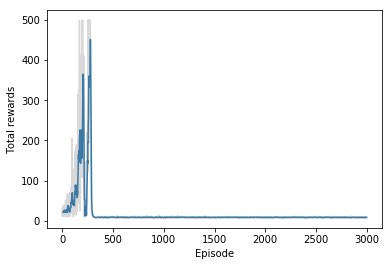

In [24]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

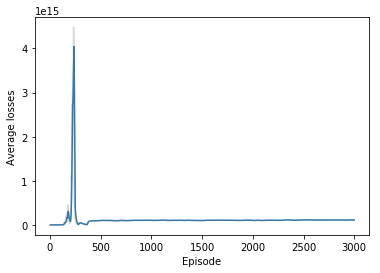

In [25]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [26]:
import gym

# Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):

        # Start a new episode/epoch
        env.reset()
        
        # number of env/rob steps
        for _ in range(test_max_steps):
            
            # Rendering the env graphics
            env.render()
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            last_action_logits = actions_logits[-1]
            
            # Take action, get new state and reward
            #action = env.action_space.sample()
            action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # The task is done or not;
            if done:
                break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.